In [232]:
import pandas as pd
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score , accuracy_score , classification_report , confusion_matrix
from sklearn.model_selection import GridSearchCV

url = "https://api.spacexdata.com/v4/launches"
res = requests.get(url)
print(res.status_code)



200


In [233]:
data = res.json()
print(len(data))

205


In [234]:
df = pd.json_normalize(data)[['flight_number','date_utc', 'rocket','cores','payloads','launchpad']]
df.head()

,flight_number,date_utc,rocket,cores,payloads,launchpad
0,1,2006-03-24T22:30:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289df35918033d3b2623', 'flight'...",[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86
1,2,2007-03-21T01:10:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289ef35918416a3b2624', 'flight'...",[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86
2,3,2008-08-03T03:34:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289ef3591814873b2625', 'flight'...","[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006e...",5e9e4502f5090995de566f86
3,4,2008-09-28T23:15:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289ef3591855dc3b2626', 'flight'...",[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86
4,5,2009-07-13T03:35:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289ef359184f103b2627', 'flight'...",[5eb0e4b7b6c3bb0006eeb1e6],5e9e4502f5090995de566f86


In [235]:
rockets = requests.get("https://api.spacexdata.com/v4/rockets").json()
rockets_df = pd.json_normalize(rockets)[['id','name','boosters']]
rockets_df.rename(columns={'id' : 'rocket','name' : 'BoosterVersion','boosters':'Block'},inplace=True)
df = df.merge(rockets_df , on = 'rocket' , how='left')
df


,flight_number,date_utc,rocket,cores,payloads,launchpad,BoosterVersion,Block
0,1,2006-03-24T22:30:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289df35918033d3b2623', 'flight'...",[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,Falcon 1,0
1,2,2007-03-21T01:10:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289ef35918416a3b2624', 'flight'...",[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,Falcon 1,0
2,3,2008-08-03T03:34:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289ef3591814873b2625', 'flight'...","[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006e...",5e9e4502f5090995de566f86,Falcon 1,0
3,4,2008-09-28T23:15:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289ef3591855dc3b2626', 'flight'...",[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,Falcon 1,0
4,5,2009-07-13T03:35:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289ef359184f103b2627', 'flight'...",[5eb0e4b7b6c3bb0006eeb1e6],5e9e4502f5090995de566f86,Falcon 1,0
...,...,...,...,...,...,...,...,...
200,198,2022-12-01T00:00:00.000Z,5e9d0d95eda69973a809d1ec,"[{'core': None, 'flight': None, 'gridfins': Tr...",[],5e9e4501f509094ba4566f84,Falcon 9,0
201,199,2022-12-01T00:00:00.000Z,5e9d0d95eda69973a809d1ec,"[{'core': None, 'flight': None, 'gridfins': No...",[63161760ffc78f3b8567071c],5e9e4502f509092b78566f87,Falcon 9,0
202,200,2022-12-01T00:00:00.000Z,5e9d0d95eda69973a809d1ec,"[{'core': None, 'flight': None, 'gridfins': No...",[6243b896af52800c6e91926e],5e9e4501f509094ba4566f84,Falcon 9,0
203,202,2022-12-01T00:00:00.000Z,5e9d0d95eda69974db09d1ed,"[{'core': None, 'flight': None, 'gridfins': Tr...",[],5e9e4502f509094188566f88,Falcon Heavy,2


In [236]:
payloads = requests.get("https://api.spacexdata.com/v4/payloads").json()
payloads_df = pd.json_normalize(payloads)[['id','mass_kg','orbit']]
payloads_df.rename(columns={'id':'payload_id','mass_kg':'PayloadMass','orbit':'Orbit'},inplace=True)

tmp = df.explode('payloads')
tmp = tmp.merge(payloads_df, left_on='payloads',right_on='payload_id',how='left')

payload_agg = tmp.groupby('flight_number',as_index=False).agg({'PayloadMass' : 'mean' , 'Orbit' : 'first'})
df = df.merge(payload_agg , on='flight_number' , how='left')
df

,flight_number,date_utc,rocket,cores,payloads,launchpad,BoosterVersion,Block,PayloadMass,Orbit
0,1,2006-03-24T22:30:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289df35918033d3b2623', 'flight'...",[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,Falcon 1,0,20.0,LEO
1,2,2007-03-21T01:10:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289ef35918416a3b2624', 'flight'...",[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,Falcon 1,0,NaN,LEO
2,3,2008-08-03T03:34:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289ef3591814873b2625', 'flight'...","[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006e...",5e9e4502f5090995de566f86,Falcon 1,0,NaN,LEO
3,4,2008-09-28T23:15:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289ef3591855dc3b2626', 'flight'...",[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,Falcon 1,0,165.0,LEO
4,5,2009-07-13T03:35:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289ef359184f103b2627', 'flight'...",[5eb0e4b7b6c3bb0006eeb1e6],5e9e4502f5090995de566f86,Falcon 1,0,200.0,LEO
...,...,...,...,...,...,...,...,...,...,...
200,198,2022-12-01T00:00:00.000Z,5e9d0d95eda69973a809d1ec,"[{'core': None, 'flight': None, 'gridfins': Tr...",[],5e9e4501f509094ba4566f84,Falcon 9,0,NaN,None
201,199,2022-12-01T00:00:00.000Z,5e9d0d95eda69973a809d1ec,"[{'core': None, 'flight': None, 'gridfins': No...",[63161760ffc78f3b8567071c],5e9e4502f509092b78566f87,Falcon 9,0,NaN,PO
202,200,2022-12-01T00:00:00.000Z,5e9d0d95eda69973a809d1ec,"[{'core': None, 'flight': None, 'gridfins': No...",[6243b896af52800c6e91926e],5e9e4501f509094ba4566f84,Falcon 9,0,NaN,SSO
203,202,2022-12-01T00:00:00.000Z,5e9d0d95eda69974db09d1ed,"[{'core': None, 'flight': None, 'gridfins': Tr...",[],5e9e4502f509094188566f88,Falcon Heavy,2,NaN,None


In [237]:
pads = requests.get("https://api.spacexdata.com/v4/launchpads").json()
pads_df = pd.json_normalize(pads)[['id','name','locality','latitude','longitude']]
pads_df.rename(columns={'id' : 'launchpad' , 'name' : 'LaunchSite' , 'latitude' : 'Latitude' , 'longitude' : 'Longitude'},inplace =True)

df = df.merge(pads_df , on='launchpad' , how='left')
df

,flight_number,date_utc,rocket,cores,payloads,launchpad,BoosterVersion,Block,PayloadMass,Orbit,LaunchSite,locality,Latitude,Longitude
0,1,2006-03-24T22:30:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289df35918033d3b2623', 'flight'...",[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,Falcon 1,0,20.0,LEO,Kwajalein Atoll,Omelek Island,9.047721,167.743129
1,2,2007-03-21T01:10:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289ef35918416a3b2624', 'flight'...",[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,Falcon 1,0,NaN,LEO,Kwajalein Atoll,Omelek Island,9.047721,167.743129
2,3,2008-08-03T03:34:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289ef3591814873b2625', 'flight'...","[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006e...",5e9e4502f5090995de566f86,Falcon 1,0,NaN,LEO,Kwajalein Atoll,Omelek Island,9.047721,167.743129
3,4,2008-09-28T23:15:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289ef3591855dc3b2626', 'flight'...",[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,Falcon 1,0,165.0,LEO,Kwajalein Atoll,Omelek Island,9.047721,167.743129
4,5,2009-07-13T03:35:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289ef359184f103b2627', 'flight'...",[5eb0e4b7b6c3bb0006eeb1e6],5e9e4502f5090995de566f86,Falcon 1,0,200.0,LEO,Kwajalein Atoll,Omelek Island,9.047721,167.743129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,198,2022-12-01T00:00:00.000Z,5e9d0d95eda69973a809d1ec,"[{'core': None, 'flight': None, 'gridfins': Tr...",[],5e9e4501f509094ba4566f84,Falcon 9,0,NaN,None,CCSFS SLC 40,Cape Canaveral,28.561857,-80.577366
201,199,2022-12-01T00:00:00.000Z,5e9d0d95eda69973a809d1ec,"[{'core': None, 'flight': None, 'gridfins': No...",[63161760ffc78f3b8567071c],5e9e4502f509092b78566f87,Falcon 9,0,NaN,PO,VAFB SLC 4E,Vandenberg Space Force Base,34.632093,-120.610829
202,200,2022-12-01T00:00:00.000Z,5e9d0d95eda69973a809d1ec,"[{'core': None, 'flight': None, 'gridfins': No...",[6243b896af52800c6e91926e],5e9e4501f509094ba4566f84,Falcon 9,0,NaN,SSO,CCSFS SLC 40,Cape Canaveral,28.561857,-80.577366
203,202,2022-12-01T00:00:00.000Z,5e9d0d95eda69974db09d1ed,"[{'core': None, 'flight': None, 'gridfins': Tr...",[],5e9e4502f509094188566f88,Falcon Heavy,2,NaN,None,KSC LC 39A,Cape Canaveral,28.608058,-80.603956


In [238]:
cores_all = requests.get("https://api.spacexdata.com/v4/cores").json()
cr = pd.json_normalize(cores_all)
cr

,block,reuse_count,rtls_attempts,rtls_landings,asds_attempts,asds_landings,last_update,launches,serial,status,id
0,NaN,0,0,0,0,0,Engine failure at T+33 seconds resulted in los...,[5eb87cd9ffd86e000604b32a],Merlin1A,lost,5e9e289df35918033d3b2623
1,NaN,0,0,0,0,0,Successful first-stage burn and transition to ...,[5eb87cdaffd86e000604b32b],Merlin2A,lost,5e9e289ef35918416a3b2624
2,NaN,0,0,0,0,0,Residual stage-1 thrust led to collision betwe...,[5eb87cdbffd86e000604b32c],Merlin1C,lost,5e9e289ef3591814873b2625
3,NaN,0,0,0,0,0,"Initially scheduled for 23–25 Sep, carried dum...",[5eb87cdbffd86e000604b32d],Merlin2C,lost,5e9e289ef3591855dc3b2626
4,NaN,0,0,0,0,0,None,[5eb87cdcffd86e000604b32e],Merlin3C,lost,5e9e289ef359184f103b2627
...,...,...,...,...,...,...,...,...,...,...,...
78,5.0,2,0,0,3,3,"Landed at ASOG as of Sep 25, 2022","[625828f25988f159024b9643, 6243aea5af52800c6e9...",B1073,active,627843db57b51b752c5c5a54
79,5.0,0,0,0,0,0,None,[],B1074,active,627843de57b51b752c5c5a55
80,5.0,0,0,0,0,0,None,[],B1075,active,627843e257b51b752c5c5a56
81,5.0,0,0,0,0,0,"Landed on JRTI as of Nov 26, 2022",[],B1076,active,633d9da235a71d1d9c66797a


In [239]:
cores_all = requests.get("https://api.spacexdata.com/v4/cores").json()
cores_master = pd.json_normalize(cores_all)[['id','serial','reuse_count']]
cores_master.rename(columns={ 'id' : 'core' , 'serial' : 'Serial' ,'reuse_count':'ReusedCount'},inplace=True)

cores_exp = df[['flight_number','cores']].explode('cores',ignore_index=True)

cores_exp_details = pd.json_normalize(cores_exp['cores'])
cores_exp = pd.concat([cores_exp[['flight_number']],cores_exp_details],axis=1)

cores_exp = cores_exp[['flight_number','core','flight','reused','gridfins','legs','landing_type','landing_attempt','landing_success']]
cores_exp.rename(columns={
    'flight':'Flights',
    'reused':'Reused',
    'gridfins':'GridFins',
    'legs':'Legs',
    'landing_type':'LandingPad', 
    'landing_success':'Outcome'
}, inplace=True)

cores_exp = cores_exp.merge(cores_master,on='core',how='left')
df = df.merge(cores_exp , on='flight_number',how='left')

In [240]:

df

,flight_number,date_utc,rocket,cores,payloads,launchpad,BoosterVersion,Block,PayloadMass,Orbit,...,core,Flights,Reused,GridFins,Legs,LandingPad,landing_attempt,Outcome,Serial,ReusedCount
0,1,2006-03-24T22:30:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289df35918033d3b2623', 'flight'...",[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,Falcon 1,0,20.0,LEO,...,5e9e289df35918033d3b2623,1.0,False,False,False,None,False,None,Merlin1A,0.0
1,2,2007-03-21T01:10:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289ef35918416a3b2624', 'flight'...",[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,Falcon 1,0,NaN,LEO,...,5e9e289ef35918416a3b2624,1.0,False,False,False,None,False,None,Merlin2A,0.0
2,3,2008-08-03T03:34:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289ef3591814873b2625', 'flight'...","[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006e...",5e9e4502f5090995de566f86,Falcon 1,0,NaN,LEO,...,5e9e289ef3591814873b2625,1.0,False,False,False,None,False,None,Merlin1C,0.0
3,4,2008-09-28T23:15:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289ef3591855dc3b2626', 'flight'...",[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,Falcon 1,0,165.0,LEO,...,5e9e289ef3591855dc3b2626,1.0,False,False,False,None,False,None,Merlin2C,0.0
4,5,2009-07-13T03:35:00.000Z,5e9d0d95eda69955f709d1eb,"[{'core': '5e9e289ef359184f103b2627', 'flight'...",[5eb0e4b7b6c3bb0006eeb1e6],5e9e4502f5090995de566f86,Falcon 1,0,200.0,LEO,...,5e9e289ef359184f103b2627,1.0,False,False,False,None,False,None,Merlin3C,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,200,2022-12-01T00:00:00.000Z,5e9d0d95eda69973a809d1ec,"[{'core': None, 'flight': None, 'gridfins': No...",[6243b896af52800c6e91926e],5e9e4501f509094ba4566f84,Falcon 9,0,NaN,SSO,...,None,NaN,None,None,None,None,None,None,NaN,NaN
231,202,2022-12-01T00:00:00.000Z,5e9d0d95eda69974db09d1ed,"[{'core': None, 'flight': None, 'gridfins': Tr...",[],5e9e4502f509094188566f88,Falcon Heavy,2,NaN,None,...,None,NaN,False,True,True,None,None,None,NaN,NaN
232,202,2022-12-01T00:00:00.000Z,5e9d0d95eda69974db09d1ed,"[{'core': None, 'flight': None, 'gridfins': Tr...",[],5e9e4502f509094188566f88,Falcon Heavy,2,NaN,None,...,None,NaN,False,True,True,None,None,None,NaN,NaN
233,202,2022-12-01T00:00:00.000Z,5e9d0d95eda69974db09d1ed,"[{'core': None, 'flight': None, 'gridfins': Tr...",[],5e9e4502f509094188566f88,Falcon Heavy,2,NaN,None,...,None,NaN,False,True,True,None,None,None,NaN,NaN


In [241]:
final_df = df[[
    'flight_number', 'date_utc', 'BoosterVersion', 'PayloadMass',
    'Orbit', 'LaunchSite', 'Outcome', 'Flights', 'GridFins',
    'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount',
    'Serial', 'Longitude', 'Latitude'
]].copy()

final_df.rename(columns={
    'flight_number': 'FlightNumber',
    'date_utc': 'Date',
    'block': 'Block'
}, inplace=True)


In [242]:
# success wale texts ka list
# success_mask = final_df['Outcome'] == True    # agar bool hai
# # ya agar string labels use kar rahe ho to:
# # success_mask = final_df['Outcome'].str.contains('Success', na=False)

# final_df['LandingClass'] = success_mask.astype(int)


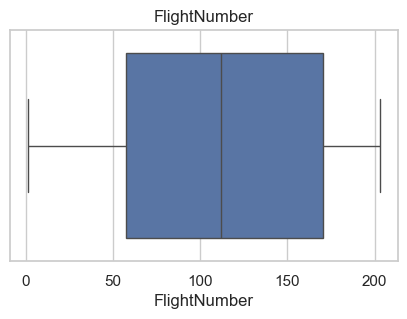

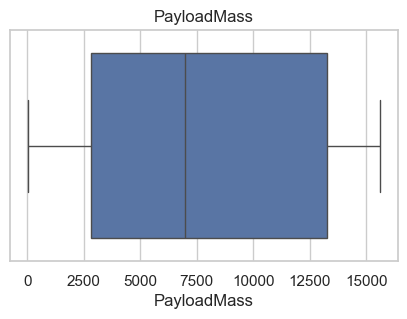

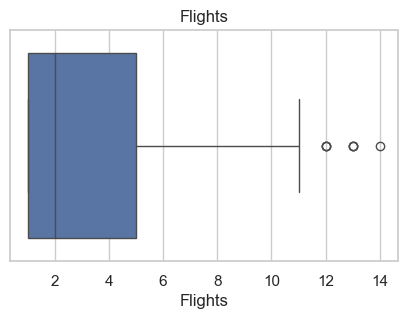

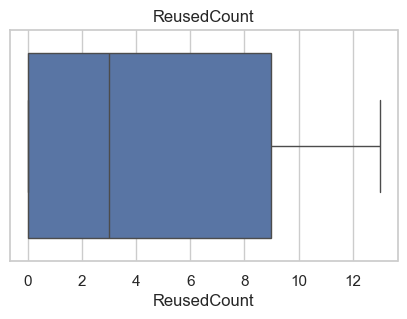

In [243]:
sns.set(style="whitegrid")

for col in ['FlightNumber', 'PayloadMass', 'Flights', 'ReusedCount']:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=final_df[col])
    plt.title(col)
    plt.show()


In [244]:
final_df

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24T22:30:00.000Z,Falcon 1,20.0,LEO,Kwajalein Atoll,None,1.0,False,False,False,None,0,0.0,Merlin1A,167.743129,9.047721
1,2,2007-03-21T01:10:00.000Z,Falcon 1,NaN,LEO,Kwajalein Atoll,None,1.0,False,False,False,None,0,0.0,Merlin2A,167.743129,9.047721
2,3,2008-08-03T03:34:00.000Z,Falcon 1,NaN,LEO,Kwajalein Atoll,None,1.0,False,False,False,None,0,0.0,Merlin1C,167.743129,9.047721
3,4,2008-09-28T23:15:00.000Z,Falcon 1,165.0,LEO,Kwajalein Atoll,None,1.0,False,False,False,None,0,0.0,Merlin2C,167.743129,9.047721
4,5,2009-07-13T03:35:00.000Z,Falcon 1,200.0,LEO,Kwajalein Atoll,None,1.0,False,False,False,None,0,0.0,Merlin3C,167.743129,9.047721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,200,2022-12-01T00:00:00.000Z,Falcon 9,NaN,SSO,CCSFS SLC 40,None,NaN,None,None,None,None,0,NaN,NaN,-80.577366,28.561857
231,202,2022-12-01T00:00:00.000Z,Falcon Heavy,NaN,None,KSC LC 39A,None,NaN,True,False,True,None,2,NaN,NaN,-80.603956,28.608058
232,202,2022-12-01T00:00:00.000Z,Falcon Heavy,NaN,None,KSC LC 39A,None,NaN,True,False,True,None,2,NaN,NaN,-80.603956,28.608058
233,202,2022-12-01T00:00:00.000Z,Falcon Heavy,NaN,None,KSC LC 39A,None,NaN,True,False,True,None,2,NaN,NaN,-80.603956,28.608058


In [245]:
final_df['Outcome_clean'] = final_df['Outcome'].fillna(False)
final_df

C:\Users\acer\AppData\Local\Temp\ipykernel_17520\483211263.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df['Outcome_clean'] = final_df['Outcome'].fillna(False)


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Outcome_clean
0,1,2006-03-24T22:30:00.000Z,Falcon 1,20.0,LEO,Kwajalein Atoll,None,1.0,False,False,False,None,0,0.0,Merlin1A,167.743129,9.047721,False
1,2,2007-03-21T01:10:00.000Z,Falcon 1,NaN,LEO,Kwajalein Atoll,None,1.0,False,False,False,None,0,0.0,Merlin2A,167.743129,9.047721,False
2,3,2008-08-03T03:34:00.000Z,Falcon 1,NaN,LEO,Kwajalein Atoll,None,1.0,False,False,False,None,0,0.0,Merlin1C,167.743129,9.047721,False
3,4,2008-09-28T23:15:00.000Z,Falcon 1,165.0,LEO,Kwajalein Atoll,None,1.0,False,False,False,None,0,0.0,Merlin2C,167.743129,9.047721,False
4,5,2009-07-13T03:35:00.000Z,Falcon 1,200.0,LEO,Kwajalein Atoll,None,1.0,False,False,False,None,0,0.0,Merlin3C,167.743129,9.047721,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,200,2022-12-01T00:00:00.000Z,Falcon 9,NaN,SSO,CCSFS SLC 40,None,NaN,None,None,None,None,0,NaN,NaN,-80.577366,28.561857,False
231,202,2022-12-01T00:00:00.000Z,Falcon Heavy,NaN,None,KSC LC 39A,None,NaN,True,False,True,None,2,NaN,NaN,-80.603956,28.608058,False
232,202,2022-12-01T00:00:00.000Z,Falcon Heavy,NaN,None,KSC LC 39A,None,NaN,True,False,True,None,2,NaN,NaN,-80.603956,28.608058,False
233,202,2022-12-01T00:00:00.000Z,Falcon Heavy,NaN,None,KSC LC 39A,None,NaN,True,False,True,None,2,NaN,NaN,-80.603956,28.608058,False


In [246]:
final_df['LandingClass'] = final_df['Outcome_clean'].astype(int)

In [247]:
print(final_df[['Outcome_clean','LandingClass']].head())
print(final_df['LandingClass'].value_counts())


   Outcome_clean  LandingClass
0          False             0
1          False             0
2          False             0
3          False             0
4          False             0
LandingClass
1    149
0     86
Name: count, dtype: int64


In [248]:
final_df.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass       41
Orbit             15
LaunchSite         0
Outcome           73
Flights           30
GridFins           9
Reused             9
Legs               9
LandingPad        71
Block              0
ReusedCount       30
Serial            30
Longitude          0
Latitude           0
Outcome_clean      0
LandingClass       0
dtype: int64

In [249]:
final_df

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Outcome_clean,LandingClass
0,1,2006-03-24T22:30:00.000Z,Falcon 1,20.0,LEO,Kwajalein Atoll,None,1.0,False,False,False,None,0,0.0,Merlin1A,167.743129,9.047721,False,0
1,2,2007-03-21T01:10:00.000Z,Falcon 1,NaN,LEO,Kwajalein Atoll,None,1.0,False,False,False,None,0,0.0,Merlin2A,167.743129,9.047721,False,0
2,3,2008-08-03T03:34:00.000Z,Falcon 1,NaN,LEO,Kwajalein Atoll,None,1.0,False,False,False,None,0,0.0,Merlin1C,167.743129,9.047721,False,0
3,4,2008-09-28T23:15:00.000Z,Falcon 1,165.0,LEO,Kwajalein Atoll,None,1.0,False,False,False,None,0,0.0,Merlin2C,167.743129,9.047721,False,0
4,5,2009-07-13T03:35:00.000Z,Falcon 1,200.0,LEO,Kwajalein Atoll,None,1.0,False,False,False,None,0,0.0,Merlin3C,167.743129,9.047721,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,200,2022-12-01T00:00:00.000Z,Falcon 9,NaN,SSO,CCSFS SLC 40,None,NaN,None,None,None,None,0,NaN,NaN,-80.577366,28.561857,False,0
231,202,2022-12-01T00:00:00.000Z,Falcon Heavy,NaN,None,KSC LC 39A,None,NaN,True,False,True,None,2,NaN,NaN,-80.603956,28.608058,False,0
232,202,2022-12-01T00:00:00.000Z,Falcon Heavy,NaN,None,KSC LC 39A,None,NaN,True,False,True,None,2,NaN,NaN,-80.603956,28.608058,False,0
233,202,2022-12-01T00:00:00.000Z,Falcon Heavy,NaN,None,KSC LC 39A,None,NaN,True,False,True,None,2,NaN,NaN,-80.603956,28.608058,False,0


In [250]:
X = final_df.drop('LandingClass',axis=1)
y = final_df['LandingClass']

In [251]:
X_train , X_test , y_train , y_test = train_test_split(
    X,y,
    test_size=0.2,
    random_state=42,
    stratify=y
)



In [252]:
X_train

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Outcome_clean
102,97,2020-06-30T19:55:00.000Z,Falcon 9,3880.0,MEO,CCSFS SLC 40,True,1.0,True,False,True,ASDS,0,12.0,B1060,-80.577366,28.561857,True
48,49,2017-10-11T22:53:00.000Z,Falcon 9,5200.0,GTO,KSC LC 39A,True,2.0,True,True,True,ASDS,0,1.0,B1031,-80.603956,28.608058,True
144,139,2021-12-01T23:20:00.000Z,Falcon 9,13260.0,PO,CCSFS SLC 40,True,9.0,True,True,True,ASDS,0,12.0,B1060,-80.577366,28.561857,True
194,188,2022-11-01T13:41:00.000Z,Falcon Heavy,8480.0,GTO,KSC LC 39A,None,1.0,True,False,True,None,2,0.0,B1065,-80.603956,28.608058,False
106,101,2020-08-30T23:18:00.000Z,Falcon 9,1600.0,SSO,CCSFS SLC 40,True,4.0,True,True,True,RTLS,0,5.0,B1059,-80.577366,28.561857,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,153,2022-03-09T13:45:00.000Z,Falcon 9,13260.0,VLEO,CCSFS SLC 40,True,4.0,True,True,True,ASDS,0,6.0,B1052,-80.577366,28.561857,True
22,23,2015-04-27T23:03:00.000Z,Falcon 9,4707.0,GTO,CCSFS SLC 40,None,1.0,False,False,False,None,0,0.0,B1016,-80.577366,28.561857,False
116,111,2020-12-13T17:30:00.000Z,Falcon 9,7000.0,GTO,CCSFS SLC 40,True,7.0,True,True,True,ASDS,0,12.0,B1051,-80.577366,28.561857,True
149,144,2022-01-06T21:49:00.000Z,Falcon 9,13260.0,VLEO,KSC LC 39A,True,4.0,True,True,True,ASDS,0,8.0,B1062,-80.603956,28.608058,True


In [253]:
numeric_features = ['FlightNumber', 'PayloadMass', 'Flights', 'ReusedCount', 'Block']
categorical_features = ['Orbit', 'LaunchSite', 'GridFins', 'Reused', 'Legs', 'LandingPad']

num_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('scaler',OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num',num_transformer,numeric_features),
        ('cat',cat_transformer,categorical_features)
    ]
)

In [254]:
clf = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model',LogisticRegression(max_iter=1000,class_weight='balanced'))
])

In [260]:
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__solver': ['lbfgs', 'liblinear']
}

grid_search = GridSearchCV(
    estimator=clf,  
    param_grid=param_grid,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1
)


grid_search.fit(X_train, y_train)


print("=== GRIDSEARCHCV RESULTS ===")
print(f"Best CV Accuracy: {grid_search.best_score_*100:.3f}%")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"All CV Results: {grid_search.cv_results_['mean_test_score']}")


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n=== TEST SET RESULTS ===")
print(f"Test Accuracy: {(best_model.score(X_test, y_test)*100):.3f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


=== GRIDSEARCHCV RESULTS ===
Best CV Accuracy: 92.589%
Best Parameters: {'model__C': 10, 'model__solver': 'lbfgs'}
All CV Results: [0.85078236 0.84537696 0.90412518 0.90412518 0.91479374 0.91479374
 0.92588905 0.92588905 0.91522048 0.91522048]

=== TEST SET RESULTS ===
Test Accuracy: 87.234%

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        17
           1       0.93      0.87      0.90        30

    accuracy                           0.87        47
   macro avg       0.86      0.87      0.86        47
weighted avg       0.88      0.87      0.87        47


Confusion Matrix:
[[15  2]
 [ 4 26]]


In [261]:
cv_scores = cross_val_score(clf,X,y,cv=5,scoring='accuracy')
print("CV scores:", cv_scores)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f'Predictions : {y_pred[:10]}')




CV scores: [0.53191489 0.80851064 0.91489362 1.         0.89361702]
Predictions : [0 1 0 0 1 1 0 1 1 1]


In [262]:
import joblib


joblib.dump(grid_search.best_estimator_, 'spacex_model.pkl')
print("✅ Model saved! 92.6% ")

✅ Model saved! 92.6% 
